In [41]:
# -----------------------------------------------------------
# 🟢 Cell 1 – Setup & Imports
# -----------------------------------------------------------
import os, time, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Enable cuDNN autotuner for conv speed
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Mixed-precision scaler
scaler = GradScaler()

# Configuration
MODEL_NAME    = 'bert-base-uncased'
MAX_LEN       = 64
BATCH_SIZE    = 8           # try bumping to fill the GPU
NUM_WORKERS   = 4           # tune to your CPU cores
EPOCHS        = 3
LR            = 2e-5
WARMUP_STEPS  = 100
SEED          = 42

# Reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

Using device: cuda


In [21]:
# Toy Dataset
sentences = [
    "This movie is great and amazing!",
    "This movie is terrible and awful.",
    "You are a wonderful person.",
    "You are a horrible person.",
    "I do not like this movie at all.",
    "Despite the rain, the picnic was fun.",
    "The service was slow, but the food was good." # Mixed example
]
# Labels: 1 for Positive, 0 for Negative
labels = [1, 0, 1, 0, 0, 1, 1] # Treating the last one as positive due to "good"Q

In [22]:
# -----------------------------------------------------------
# 🟢 Cell 2 – Data Preparation
# -----------------------------------------------------------
print(f"\nLoading tokenizer ({MODEL_NAME})...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class ToyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts, self.labels = texts, labels
        self.tokenizer, self.max_len = tokenizer, max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids':     enc['input_ids'].squeeze(0),
            'attention_mask':enc['attention_mask'].squeeze(0),
            'labels':        torch.tensor(self.labels[idx], dtype=torch.long)
        }

dataset    = ToyDataset(sentences, labels, tokenizer, MAX_LEN)
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE.type == "cuda")
)


Loading tokenizer (bert-base-uncased)...


In [36]:
# -----------------------------------------------------------
# 🟢 Cell 3 – Model & Optimizer (FP32 weights + AMP forward)
# -----------------------------------------------------------
print(f"\nLoading model ({MODEL_NAME})…")
torch.cuda.empty_cache()

# Load in default (FP32) precision
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=True,
    low_cpu_mem_usage=True
)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total optimization steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max sequence length: {MAX_LEN}")


Loading model (bert-base-uncased)…


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total optimization steps: 3
Warmup steps: 100
Batch size: 8
Max sequence length: 64


In [40]:
# -----------------------------------------------------------
# 🟢 Cell 4 – Training Loop (FP32 weights + AMP forward)
# -----------------------------------------------------------
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import time

print(f"\nStarting fine-tuning for {EPOCHS} epochs...\n")

model.train()
scaler = GradScaler()
optimizer.zero_grad(set_to_none=True)

for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    t0 = time.time()

    for batch in tqdm(data_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        input_ids      = batch['input_ids'].to(DEVICE, non_blocking=True)
        attention_mask = batch['attention_mask'].to(DEVICE, non_blocking=True)
        labels         = batch['labels'].to(DEVICE, non_blocking=True)

        with autocast():  # forward & activations in FP16
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        optimizer.zero_grad(set_to_none=True)
        scheduler.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(data_loader)
    print(f"Epoch {epoch}/{EPOCHS} — loss: {avg_loss:.4f} — time: {time.time() - t0:.1f}s")

print("\nFine-tuning complete.")


/tmp/ipykernel_7129/1939163377.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting fine-tuning for 3 epochs...



Epoch 1/3:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_7129/1939163377.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # forward & activations in FP16


Epoch 1/3 — loss: 0.7100 — time: 0.4s


Epoch 2/3 — loss: 0.7474 — time: 0.3s


Epoch 3/3 — loss: 0.7881 — time: 0.3s

Fine-tuning complete.


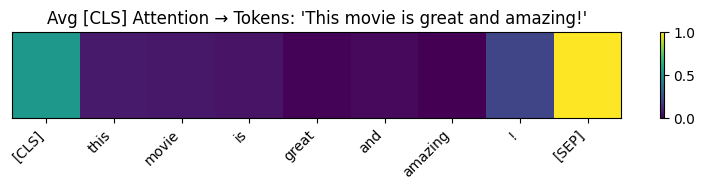

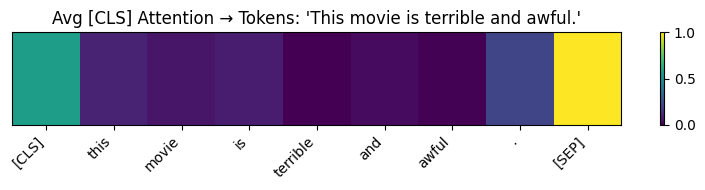

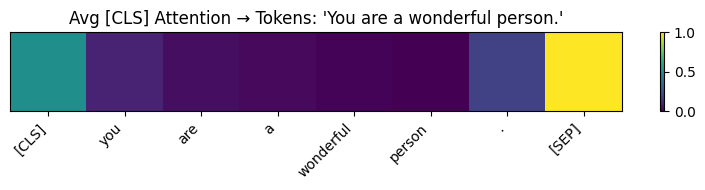

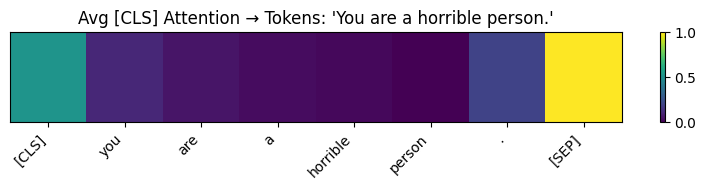

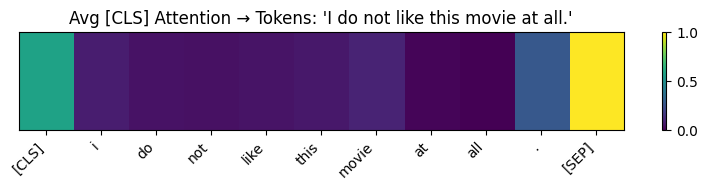

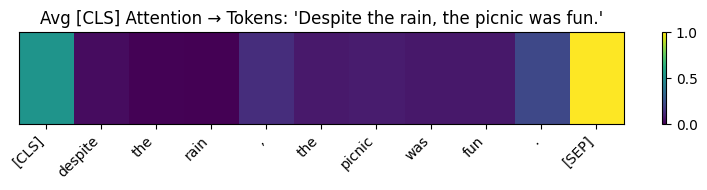

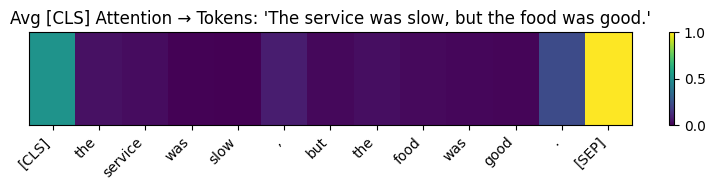

In [43]:
# -----------------------------------------------------------
# 🟢 Cell 5 – Attention Visualization
# -----------------------------------------------------------

def visualize_attention(model, tokenizer, text, device, max_len):
    """Visualizes average attention from [CLS] token for the input text."""
    model.eval()

    # Tokenize and prepare inputs
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Forward pass with attention outputs
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )

    attentions = outputs.attentions  # Tuple[layers x (batch, heads, seq_len, seq_len)]
    if not attentions:
        raise RuntimeError("Model did not return attentions. Ensure `output_attentions=True`.")

    num_layers = len(attentions)
    seq_len = attentions[0].size(-1)

    # Sum CLS->all attention across layers & heads
    cls_attn_sum = torch.zeros(seq_len, device=device)
    for layer_attn in attentions:
        # layer_attn: [1, num_heads, seq_len, seq_len]
        # average over heads
        avg_head = layer_attn[0].mean(dim=0)            # [seq_len, seq_len]
        cls_to_all = avg_head[0]                       # [seq_len]
        cls_attn_sum += cls_to_all

    # Average over layers
    avg_cls_attn = cls_attn_sum / num_layers
    attn_scores = avg_cls_attn.cpu().numpy()

    # Convert tokens and mask out padding
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().tolist())
    mask = attention_mask[0].cpu().numpy().astype(bool)
    tokens = [tok for tok, m in zip(tokens, mask) if m]
    attn_scores = attn_scores[mask]

    # Normalize for better contrast
    min_s, max_s = attn_scores.min(), attn_scores.max()
    if max_s > min_s:
        norm_scores = (attn_scores - min_s) / (max_s - min_s)
    else:
        norm_scores = np.zeros_like(attn_scores)

    # Plot
    plt.figure(figsize=(max(8, len(tokens)*0.5), 2))
    im = plt.imshow([norm_scores], aspect='auto', origin='lower')
    plt.colorbar(im)
    plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=45, ha='right')
    plt.yticks([])
    plt.title(f"Avg [CLS] Attention → Tokens: '{text}'")
    plt.tight_layout()
    plt.show()

# Example usage:
for sent in sentences:
    visualize_attention(model, tokenizer, sent, DEVICE, MAX_LEN)